# 第二课 词向量

第二课学习目标
- 学习词向量的概念
- 用Skip-thought模型训练词向量
- 学习使用PyTorch dataset和dataloader
- 学习定义PyTorch模型
- 学习torch.nn中常见的Module
    - Embedding
- 学习常见的PyTorch operations
    - bmm
    - logsigmoid
- 保存和读取PyTorch模型
    

第二课使用的训练数据可以从以下链接下载到。

链接:https://pan.baidu.com/s/1tFeK3mXuVXEy3EMarfeWvg  密码:v2z5

在这一份notebook中，我们会（尽可能）尝试复现论文[Distributed Representations of Words and Phrases and their Compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)中训练词向量的方法. 我们会实现Skip-gram模型，并且使用论文中noice contrastive sampling的目标函数。

这篇论文有很多模型实现的细节，这些细节对于词向量的好坏至关重要。我们虽然无法完全复现论文中的实验结果，主要是由于计算资源等各种细节原因，但是我们还是可以大致展示如何训练词向量。

以下是一些我们没有实现的细节
- subsampling：参考论文section 2.3

In [1]:
import torch
import torch.nn as nn  #神经网络工具箱torch.nn 
import torch.nn.functional as F  #神经网络函数torch.nn.functional
import torch.utils.data as tud  #Pytorch读取训练集需要用到torch.utils.data类

**两个模块的区别：**[torch.nn 和 torch.functional 的区别](https://blog.csdn.net/hawkcici160/article/details/80140059)

In [2]:
from torch.nn.parameter import Parameter  #参数更新和优化函数

from collections import Counter #Counter 计数器
import numpy as np 
import random
import math 

import pandas as pd
import scipy #SciPy是基于NumPy开发的高级模块，它提供了许多数学算法和函数的实现
import sklearn
from sklearn.metrics.pairwise import cosine_similarity #余弦相似度函数

In [3]:
USE_CUDA = torch.cuda.is_available() #有GPU可以用

# 为了保证实验结果可以复现，我们经常会把各种random seed固定在某一个值
random.seed(53113)
np.random.seed(53113)
torch.manual_seed(53113)
if USE_CUDA:
    torch.cuda.manual_seed(53113)
    
# 设定一些超参数   
K = 10 # number of negative samples 负样本随机采样数量
C = 3 # nearby words threshold 指定周围三个单词进行预测
NUM_EPOCHS = 1 # The number of epochs of training 迭代轮数
MAX_VOCAB_SIZE = 20000 # the vocabulary size 词汇表多大
BATCH_SIZE = 64 # the batch size 每轮迭代1个batch的数量
LEARNING_RATE = 0.2 # the initial learning rate #学习率
EMBEDDING_SIZE = 100 #词向量维度
       
    
LOG_FILE = "word-embedding.log"

# tokenize函数，把一篇文本转化成一个个单词
def word_tokenize(text):
    return text.split()

- 从文本文件中读取所有的文字，通过这些文本创建一个vocabulary
- 由于单词数量可能太大，我们只选取最常见的MAX_VOCAB_SIZE个单词
- 我们添加一个UNK单词表示所有不常见的单词
- 我们需要记录单词到index的mapping，以及index到单词的mapping，单词的count，单词的(normalized) frequency，以及单词总数。

In [4]:
# with open("text8.test.txt", "r", encoding='utf8') as fin: #读入文件
#     text = fin.read()
# text = [w for w in word_tokenize(text.lower())] 
# (text[:100])

In [5]:
with open("corpus_havestp_C.txt", "r", encoding='utf8') as fin: #读入文件
    text = fin.read()
    
text = [w for w in word_tokenize(text.lower())] 
#分词，在这里类似于text.split()

vocab = dict(Counter(text).most_common(MAX_VOCAB_SIZE-1))
#字典格式，把（MAX_VOCAB_SIZE-1）个最频繁出现的单词取出来，-1是留给不常见的单词

vocab["<unk>"] = len(text) - np.sum(list(vocab.values()))
#unk表示不常见单词数=总单词数-常见单词数
#这里计算的到vocab["<unk>"]=29999

idx_to_word = [word for word in vocab.keys()] 
#取出字典的所有单词key

word_to_idx = {word:i for i, word in enumerate(idx_to_word)}
#取出所有单词的单词和对应的索引，索引值与单词出现次数相反，最常见单词索引为0。

word_counts = np.array([count for count in vocab.values()], dtype=np.float32)
#所有单词的频数values

word_freqs = word_counts / np.sum(word_counts)
#所有单词的频率

word_freqs = word_freqs ** (3./4.)
#论文里乘以3/4次方

word_freqs = word_freqs / np.sum(word_freqs) # 用来做 negative sampling
# 重新计算所有单词的频率

VOCAB_SIZE = len(idx_to_word) #词汇表单词数30000=MAX_VOCAB_SIZE
VOCAB_SIZE

20000

### 实现Dataloader

一个dataloader需要以下内容：

- 把所有text编码成数字，然后用subsampling预处理这些文字。
- 保存vocabulary，单词count，normalized word frequency
- 每个iteration sample一个中心词
- 根据当前的中心词返回context单词
- 根据中心词sample一些negative单词
- 返回单词的counts

这里有一个好的tutorial介绍如何使用[PyTorch dataloader](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).
为了使用dataloader，我们需要定义以下两个function:

- ```__len__``` function需要返回整个数据集中有多少个item
- ```__get__``` 根据给定的index返回一个item

有了dataloader之后，我们可以轻松随机打乱整个数据集，拿到一个batch的数据等等。

In [6]:
class WordEmbeddingDataset(tud.Dataset): #tud.Dataset父类
    def __init__(self, text, word_to_idx, idx_to_word, word_freqs, word_counts):
        ''' text: a list of words, all text from the training dataset
            word_to_idx: the dictionary from word to idx
            idx_to_word: idx to word mapping
            word_freq: the frequency of each word
            word_counts: the word counts
        '''
        super(WordEmbeddingDataset, self).__init__() #初始化模型
        self.text_encoded = [word_to_idx.get(t, VOCAB_SIZE-1) for t in text]
        #字典 get() 函数返回指定键的值（第一个参数），如果值不在字典中返回默认值（第二个参数）。
        #取出text里每个单词word_to_idx字典里对应的索引,不在字典里返回"<unk>"的索引
        #"<unk>"的索引=29999，get括号里第二个参数应该写word_to_idx["<unk>"]，不应该写VOCAB_SIZE-1，虽然数值一样。
        
        self.text_encoded = torch.Tensor(self.text_encoded).long()
        #变成tensor类型，这里变成longtensor，也可以torch.LongTensor(self.text_encoded)
        
        self.word_to_idx = word_to_idx #保存数据
        self.idx_to_word = idx_to_word  #保存数据
        self.word_freqs = torch.Tensor(word_freqs) #保存数据
        self.word_counts = torch.Tensor(word_counts) #保存数据
        
    def __len__(self): #数据集有多少个item 
        #魔法函数__len__
        ''' 返回整个数据集（所有单词）的长度
        '''
        return len(self.text_encoded) #所有单词的总数
        
    def __getitem__(self, idx):
        #魔法函数__getitem__，这个函数跟普通函数不一样
        ''' 这个function返回以下数据用于训练
            - 中心词
            - 这个单词附近的(positive)单词
            - 随机采样的K个单词作为negative sample
        '''
        center_word = self.text_encoded[idx] 
        #print(center_word)
        #中心词索引
        #这里__getitem__函数是个迭代器，idx代表了所有的单词索引。
        
        pos_indices = list(range(idx-C, idx)) + list(range(idx+1, idx+C+1))
        #周围词索引的索引，比如idx=0时。pos_indices = [-3, -2, -1, 1, 2, 3] 
        #老师讲这里的时候，我不是特别明白
        
        pos_indices = [i%len(self.text_encoded) for i in pos_indices]
        #range(idx+1, idx+C+1)超出词汇总数时，需要特别处理，取余数
        
        pos_words = self.text_encoded[pos_indices]
        #周围词索引，就是希望出现的正例单词
        #print(pos_words)
        
        neg_words = torch.multinomial(self.word_freqs, K * pos_words.shape[0], True)
        #负例采样单词索引，torch.multinomial作用是对self.word_freqs做K * pos_words.shape[0]次取值，输出的是self.word_freqs对应的下标。
        #取样方式采用有放回的采样，并且self.word_freqs数值越大，取样概率越大。
        #每个正确的单词采样K个，pos_words.shape[0]是正确单词数量
        #print(neg_words)
        
        return center_word, pos_words, neg_words 

创建dataset和dataloader

In [7]:
dataset = WordEmbeddingDataset(text, word_to_idx, idx_to_word, word_freqs, word_counts)
# list(dataset) 可以把尝试打印下center_word, pos_words, neg_words看看

dataloader = tud.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)     
# next(iter(dataloader))

torch.utils.data.DataLoader理解：https://blog.csdn.net/qq_36653505/article/details/83351808

### 定义PyTorch模型

In [8]:
class EmbeddingModel(nn.Module):
    def __init__(self, vocab_size, embed_size):
        ''' 初始化输出和输出embedding
        '''
        super(EmbeddingModel, self).__init__()
        self.vocab_size = vocab_size  #30000
        self.embed_size = embed_size  #100
        
        initrange = 0.5 / self.embed_size
        self.out_embed = nn.Embedding(self.vocab_size, self.embed_size, sparse=False)
        #模型输出nn.Embedding(30000, 100)
        self.out_embed.weight.data.uniform_(-initrange, initrange)
        #权重初始化的一种方法
        
        
        self.in_embed = nn.Embedding(self.vocab_size, self.embed_size, sparse=False)
         #模型输入nn.Embedding(30000, 100)
        self.in_embed.weight.data.uniform_(-initrange, initrange)
        #权重初始化的一种方法
        
        
    def forward(self, input_labels, pos_labels, neg_labels):
        '''
        input_labels: 中心词, [batch_size]
        pos_labels: 中心词周围 context window 出现过的单词 [batch_size * (window_size * 2)]
        neg_labelss: 中心词周围没有出现过的单词，从 negative sampling 得到 [batch_size, (window_size * 2 * K)]
        
        return: loss, [batch_size]
        '''
        
        batch_size = input_labels.size(0)  #input_labels是输入的标签，tud.DataLoader()返回的。相已经被分成batch了。
        
        input_embedding = self.in_embed(input_labels) 
        # B * embed_size
        #这里估计进行了运算：（128,30000）*（30000,100）= 128(B) * 100 (embed_size)
        
        pos_embedding = self.out_embed(pos_labels) # B * (2*C) * embed_size
        #同上，增加了维度(2*C)，表示一个batch有B组周围词单词，一组周围词有(2*C)个单词，每个单词有embed_size个维度。
        
        neg_embedding = self.out_embed(neg_labels) # B * (2*C * K) * embed_size
        #同上，增加了维度(2*C*K)
      
    
        #torch.bmm()为batch间的矩阵相乘（b,n.m)*(b,m,p)=(b,n,p)
        log_pos = torch.bmm(pos_embedding, input_embedding.unsqueeze(2)).squeeze() # B * (2*C)
        log_neg = torch.bmm(neg_embedding, -input_embedding.unsqueeze(2)).squeeze() # B * (2*C*K)
        #unsqueeze(2)指定位置升维，.squeeze()压缩维度。
        
        #下面loss计算就是论文里的公式
        log_pos = F.logsigmoid(log_pos).sum(1)
        log_neg = F.logsigmoid(log_neg).sum(1) # batch_size     
        loss = log_pos + log_neg
        
        return -loss
    
    def input_embeddings(self):   #取出self.in_embed数据参数
        return self.in_embed.weight.data.cpu().numpy()
        

定义一个模型以及把模型移动到GPU

In [9]:
model = EmbeddingModel(VOCAB_SIZE, EMBEDDING_SIZE)
#得到model，有参数，有loss，可以优化了

USE_CUDA = 0
if USE_CUDA:
    model = model.cuda()

下面是评估模型的代码，以及训练模型的代码

In [10]:
def evaluate(filename, embedding_weights): 
    if filename.endswith(".csv"):
        data = pd.read_csv(filename, sep=",")
    else:
        data = pd.read_csv(filename, sep="\t")
    human_similarity = []
    model_similarity = []
    for i in data.iloc[:, 0:2].index:
        word1, word2 = data.iloc[i, 0], data.iloc[i, 1]
        if word1 not in word_to_idx or word2 not in word_to_idx:
            continue
        else:
            word1_idx, word2_idx = word_to_idx[word1], word_to_idx[word2]
            word1_embed, word2_embed = embedding_weights[[word1_idx]], embedding_weights[[word2_idx]]
            model_similarity.append(float(sklearn.metrics.pairwise.cosine_similarity(word1_embed, word2_embed)))
            human_similarity.append(float(data.iloc[i, 2]))

    return scipy.stats.spearmanr(human_similarity, model_similarity)# , model_similarity

def find_nearest(word):
    index = word_to_idx[word]
    embedding = embedding_weights[index]
    cos_dis = np.array([scipy.spatial.distance.cosine(e, embedding) for e in embedding_weights])
    return [idx_to_word[i] for i in cos_dis.argsort()[:10]]

训练模型：
- 模型一般需要训练若干个epoch
- 每个epoch我们都把所有的数据分成若干个batch
- 把每个batch的输入和输出都包装成cuda tensor
- forward pass，通过输入的句子预测每个单词的下一个单词
- 用模型的预测和正确的下一个单词计算cross entropy loss
- 清空模型当前gradient
- backward pass
- 更新模型参数
- 每隔一定的iteration输出模型在当前iteration的loss，以及在验证数据集上做模型的评估

In [11]:
# for i, (input_labels, pos_labels, neg_labels) in enumerate(dataloader):
#         print(input_labels, pos_labels, neg_labels)
#         if i>5:
#             break


tensor([19999, 19999,  2035,  2935, 19999,    49, 19999,   799, 10964, 19999,
           65,    10,    58,   308, 19999, 19999, 19999, 19999,  1535, 19999,
        19999, 12049,   712,  5072,   280,  9481,  1035,   196,  1855,   204,
           55,   294,   171,  1188,    32, 19999,  5829,   842,    20, 19999,
          590,  3357,    11,  1046,   775,     5, 19999,  7946,  3762,  4181,
           10,  3569,    32,  1533, 19999,  5286,  5549,   154, 19999,   930,
          368,   547,   138,     6]) tensor([[15234,  1030,  6248,  3003,  3800,  7867],
        [11756, 19999, 17770, 19999, 19999, 19999],
        [  586,  9116,  1245,    91,    10, 10663],
        [ 2935,   116,  3325,   135,   227,    26],
        [19999,   661,  1916, 11250, 19999,  5804],
        [19999,  3237,  2572,    18, 19999,   167],
        [ 1445, 19999, 19999, 16860,   187, 19999],
        [19999, 19999,    18,  5327, 14668, 19999],
        [  473,   354,    47, 12238, 19999,    56],
        [19999, 19999, 1999

        [10875,  4226,   506,  ...,   298,   605,   581]])
tensor([  129,    16,   244, 19999,   392, 19999,   653, 19999,  1349,  2141,
          244,   727,  8009,  2189,   215, 19999,   457,  1908, 19999,  2902,
           46, 19999, 19999, 14918,   264, 19999, 12723,   365, 14880,  4177,
          888,  2940, 10329,   144,  3097, 19999, 19999,   126,  1355, 19999,
         5785,   687, 18725,  5697,  6292, 17160,   321,   133, 19999,  1543,
          501,   251, 19999,  3087,  1441,    20,  4224,  3126,  6801,  4274,
         3458,   168, 11779, 19999]) tensor([[ 5243,  5575,   427,  2334,  7036, 19064],
        [ 3077, 19999,   762,  6603,  4386, 19999],
        [ 3763,  2594, 12273,  7805, 19999,  1204],
        [  166,  1629,   189,     1,     0,     1],
        [19999,   523,   724, 16900, 19999,   523],
        [  303, 11777,  1245, 19999,  1128, 11350],
        [   63,  4888,   576,   265,   615,  6612],
        [19999,  1824, 19999, 19999, 11680,  7049],
        [   40,  100

        [ 4821,  1389,    85,  ..., 15156,  2830,   123]])
tensor([  408, 12225,  2485, 19999,  7588, 19999,   174,  2150,   206,  1954,
           44,  6066,  9765,  1017,   475,  1476,  1177,     5,   319,    83,
         8575, 19999,   142,    88,   739,  2409,   274, 19999,  6885,   146,
          904,   162,  1707,  3045,  3999,  3161,  3806, 19999,   264,  1726,
         2185, 11659,    22, 19999,   405, 18232,  1987,  2428,   591,  4046,
          374,  6927,  2891,  3315,   212,   355,   411,  4024,    19, 19999,
         1180,   306,  4172,  1823]) tensor([[15826, 13549,   265,  2046,  1467,  6852],
        [13151,    33, 12548,  1011,  3290,  3415],
        [ 9105, 19999,  3571,  3807, 19999, 19999],
        [14874, 15890,  1513, 14874,  1691, 14874],
        [ 1116, 15365, 13671,   364, 19891, 19999],
        [17285,   155,  1129,   516,   290,  2975],
        [ 9133, 19999, 19999,  5732, 19999,  8523],
        [ 2340,  2113,  7550,  2424, 19999,   958],
        [   35, 1624

        [ 3648,   509,  9311,  ...,  9360,   462,  1499]])
tensor([19999,  4621,  1471,  2409, 12044, 13225,    36,   327, 19999,    87,
          861,   160,   200,  4560,   703, 19174,  3586,  4599,   821,   552,
         3119,   113, 19999,     3,   422,   197,  3878, 19999,   988, 19999,
         1802, 19999,  6105,   224, 10410,  7800,   757,  3834,  2957,  3259,
         3763,  3770,     0,  2139,  1117,  2136, 16374,    56, 19999,  4610,
           16,   298, 19999, 12878,   108, 14068,   214, 19999, 19999,  3974,
           95,  3251,  1943, 10237]) tensor([[10153,  2794,   583,    32,     4,    76],
        [ 6228,     4,     6,  3150,   864,   321],
        [  547, 19999,  1876,    92,  8034,   154],
        [ 7128, 19999, 17096, 11259, 19999,  2815],
        [ 3631, 17113,  2074,   276,  1594,  4576],
        [   33,  1664,  6940,   114,   197, 19999],
        [19999,  1242,   916,   916,  1703, 13327],
        [   25,    53,  1681,  2594, 19999,   503],
        [   29,   94

In [12]:
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
#随机梯度下降

for e in range(NUM_EPOCHS): #开始迭代
    for i, (input_labels, pos_labels, neg_labels) in enumerate(dataloader):
        #print(input_labels, pos_labels, neg_labels)
        
        # TODO
        input_labels = input_labels.long() #longtensor
        pos_labels = pos_labels.long()
        neg_labels = neg_labels.long()
        if USE_CUDA:
            input_labels = input_labels.cuda()
            pos_labels = pos_labels.cuda()
            neg_labels = neg_labels.cuda()
       
        #下面第一节课都讲过的   
        optimizer.zero_grad() #梯度归零
        loss = model(input_labels, pos_labels, neg_labels).mean()
        
        loss.backward()
        optimizer.step()
       
        #打印结果。
        if i % 1000 == 0:
            with open(LOG_FILE, "a") as fout:
                fout.write("epoch: {}, iter: {}, loss: {}\n".format(e, i, loss.item()))
                print("epoch: {}, iter: {}, loss: {}".format(e, i, loss.item()))
            
        
#         if i % 2000 == 0:
#             embedding_weights = model.input_embeddings()
#             sim_simlex = evaluate("simlex-999.txt", embedding_weights)
#             sim_men = evaluate("men.txt", embedding_weights)
#             sim_353 = evaluate("wordsim353.csv", embedding_weights)
#             with open(LOG_FILE, "a") as fout:
#                 print("epoch: {}, iteration: {}, simlex-999: {}, men: {}, sim353: {}, nearest to monster: {}\n".format(
#                     e, i, sim_simlex, sim_men, sim_353, find_nearest("monster")))
#                 fout.write("epoch: {}, iteration: {}, simlex-999: {}, men: {}, sim353: {}, nearest to monster: {}\n".format(
#                     e, i, sim_simlex, sim_men, sim_353, find_nearest("monster")))
        if i > 3e3:
            break
    embedding_weights = model.input_embeddings()
    np.save("embedding-{}".format(EMBEDDING_SIZE), embedding_weights)
    torch.save(model.state_dict(), "embedding-{}.th".format(EMBEDDING_SIZE))

epoch: 0, iter: 0, loss: 45.747745513916016
epoch: 0, iter: 1000, loss: 41.274600982666016
epoch: 0, iter: 2000, loss: 39.07835388183594
epoch: 0, iter: 3000, loss: 32.79408645629883


In [13]:
model.load_state_dict(torch.load("embedding-{}.th".format(EMBEDDING_SIZE)))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

(20000, 100)

## 在 MEN 和 Simplex-999 数据集上做评估

In [14]:
embedding_weights = model.input_embeddings()
print("simlex-999", evaluate("simlex-999.txt", embedding_weights))
print("men", evaluate("men.txt", embedding_weights))
print("wordsim353", evaluate("wordsim353.csv", embedding_weights))

simlex-999 SpearmanrResult(correlation=nan, pvalue=nan)
men SpearmanrResult(correlation=nan, pvalue=nan)
wordsim353 SpearmanrResult(correlation=nan, pvalue=nan)


## 寻找nearest neighbors

In [43]:
# for word in ["good", "fresh", "monster", "green", "like", "america", "chicago", "work", "computer", "language"]:
#     print(word, find_nearest(word))
for word in ['这', '电脑','美国',]:
    print(word, find_nearest(word))

KeyError: '这'

## 词向量可视化

(30, 100) (30, 2)


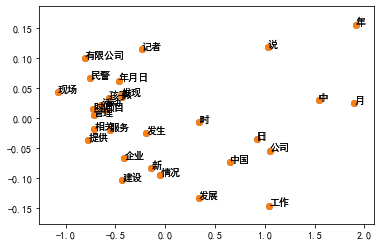

In [46]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
words = idx_to_word[:30]
X = embedding_weights[:30]
X_2 = PCA(n_components=2).fit_transform(X)
print(X.shape, X_2.shape)

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.scatter(X_2[:, 0], X_2[:, 1])  # 散点图的xy坐标
for i, word in enumerate(words):
    plt.annotate(word, xy=(X_2[i, 0], X_2[i, 1]))
plt.show()

## 单词之间的关系

In [17]:
man_idx = word_to_idx["man"] 
king_idx = word_to_idx["king"] 
woman_idx = word_to_idx["woman"]
embedding = embedding_weights[woman_idx] - embedding_weights[man_idx] + embedding_weights[king_idx]
cos_dis = np.array([scipy.spatial.distance.cosine(e, embedding) for e in embedding_weights])
for i in cos_dis.argsort()[:20]:
    print(idx_to_word[i])

KeyError: 'man'